In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data loading and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import os
import xgboost as xgb

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras import regularizers
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score,mean_squared_error, recall_score, precision_score,f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
root_dir = '/content/drive/MyDrive/TFM'
data = pd.read_csv(os.path.sep.join([root_dir,'cell2cell.csv']))

In [4]:
#Normalizing data
y = data.Churn
X = data.copy()
X = X.drop(columns = ['Churn'])

StdS = StandardScaler()
MinMax =MinMaxScaler()
Xs = StdS.fit_transform(X)
Xm = MinMax.fit_transform(X)
Xn=np.array(X)

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((47536, 30), (20373, 30))

#Tunning hyperparameters

##Functions defined

In [5]:
#Tunning hyperparameters functions
def main_model(layers_dims):
    L = len(layers_dims)
   
    model = Sequential()
    
    for l in range(1, L):
        if l == 1:
            # Capa de entrada
            model.add(Dense(layers_dims[l], input_dim = layers_dims[0], kernel_initializer='normal', activation = 'relu'))
            model.add(Dropout(0.5))
        elif l == L - 1:
            # Última capa
            model.add(Dense(layers_dims[l], kernel_initializer='normal', activation = 'sigmoid'))
        else:
            # Capas ocultas
            model.add(Dense(layers_dims[l], kernel_initializer='normal', activation = 'relu'))
            model.add(Dropout(0.5))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

def best_model(X_train, y_train, X_test, y_test, layers_dims, epochs, batch_size):
    nn_df_columns = {"Configuration":[], "Network architecture": [], "Epochs": [], "Batch size": [], 
                     "Time": [], "Accuracy": [], "Validation Accuracy": [], 'Validation Loss':[]}
    num=0
    for l in layers_dims:
        for e in epochs:
            for b in batch_size:
                start_time = timeit.default_timer()

                model = main_model(layers_dims=l)                
                mfit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=e, batch_size=b, verbose=0)
                  
                accuracy = mfit.history["accuracy"][-1]
                val_loss = model.evaluate(X_test, y_test, verbose=2)[0]
                val_accuracy = model.evaluate(X_test, y_test, verbose=2)[1]

                elapsed = timeit.default_timer() - start_time
          
                nn_df_columns['Configuration'].append(num)
                nn_df_columns['Network architecture'].append(l)
                nn_df_columns['Epochs'].append(e)
                nn_df_columns['Batch size'].append(b)
                nn_df_columns['Time'].append(elapsed)
                nn_df_columns['Accuracy'].append(accuracy)
                nn_df_columns['Validation Accuracy'].append(val_accuracy)
                nn_df_columns['Validation Loss'].append(val_loss)

                num+=1
    return pd.DataFrame(nn_df_columns)

def best_lr(lrate, n_epochs, batch_size):
    acc = []
    t = [] 
    for lr in lrate:
        model = Sequential()
        model.add(Dense(250, input_shape=(X.shape[1],), kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(250, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        
        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        
        start_time = timeit.default_timer()
        history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=n_epochs, batch_size=batch_size, verbose=0)
        t.append(timeit.default_timer() - start_time)
        acc.append(model.evaluate(X_test, y_test, verbose=2)[1])

    return history, model, t, acc

##Optimize layers, epochs and batch size

In [6]:
#Optimizing layers, epochs and batch size
#layers_dims = [[29, 250, 250,1], [29, 250, 1]]
#epochs = [100, 200]
#batch_size = [64, 128]

#results = best_model(X_train, y_train, X_test, y_test, layers_dims, epochs, batch_size)
#results

##Optimize learning rate

In [7]:
#Optimizing learning rate
#lr = [0.0001, 0.001, 0.01, 0.1]
#history, model, t, acc = best_lr(lr, 100, 64)

In [8]:
#Ploting lr vs accuracy and training times
#lr = [0.0001, 0.001, 0.01, 0.1]
#plt.plot(lr, t, marker="o")
#plt.title('Learning rate training times')
#plt.ylabel('Training time (s)')
#plt.xlabel('Learning rate')
#plt.xticks(lr)
#plt.show()

#plt.plot(lr, acc, marker="o")
#plt.title('Learning rate accuracies')
#plt.ylabel('Accuracy')
#plt.xlabel('Learning rate')
#plt.xticks(lr)
#plt.show()

#Deep-BP-ANN implementation with selected parameters

##K-fold cross-validation

In [9]:
def build_model():
    model = Sequential()
    model.add(Dense(250, input_shape=(30,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def plot_result(train_data, val_data):
  plt.figure(figsize=(12,6))
  #labels = ['1st Fold','2nd Fold', '3rd Fold', '4th Fold', '5th Fold','6th Fold','7th Fold', '8th Fold', '9th Fold', '10th Fold']
  labels = ['1st Fold','2nd Fold', '3rd Fold', '4th Fold', '5th Fold']
  X_axis = np.arange(len(labels))
  ax = plt.gca()
  ax.set_facecolor('w')
  plt.ylim(0.4, 0.9)
  plt.bar(X_axis-0.2, train_data, 0.4, color='darkblue', label='Training')
  plt.bar(X_axis+0.2, val_data, 0.4, color='lightblue', label='Validation')
  plt.title("K-fold validation", fontsize=20)
  plt.xticks(X_axis, labels)
  plt.xlabel("Deep-BP-ANN", fontsize=14)
  plt.ylabel("Accuracy", fontsize=14)
  plt.legend()
  plt.grid(True)
  plt.show()


<ipython-input-10-75be49cf9bef>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_model)


1189/1189 [==============================] - 2s 1ms/step


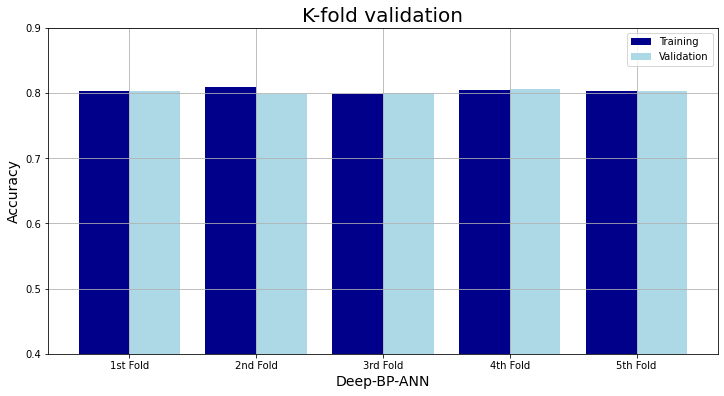

In [10]:
keras_clf = KerasClassifier(build_model)
kfold = KFold(n_splits=5, shuffle=True)

kf_cv_scores = cross_validate(keras_clf, X_train, y_train, cv=kfold, scoring = 'accuracy', return_train_score=True)
plot_result(kf_cv_scores['train_score'], kf_cv_scores['test_score'])

##Model implementation

In [11]:
#Selected hyperparameters
n_epochs = 300
batch_size = 64
verbose = 2
lr = 0.0001
t = time.time()

#Callbacks
model_save = os.path.sep.join([root_dir,'model_bests_weights.hdf5'])
checkpoint = ModelCheckpoint(model_save, monitor= 'val_accuracy', mode='max',save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', mode= 'min', patience=10, verbose=1, min_delta=1e-4) 
callbacks_list = [checkpoint, early_stop]

#Defining model
model = Sequential()
model.add(Dense(250, input_shape=(X.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#Fitting model on the dataset
mfit = model.fit(X_train, y_train, verbose=verbose, validation_data=(X_test, y_test), batch_size=batch_size, epochs=n_epochs, callbacks = callbacks_list)

print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.80803, saving model to /content/drive/MyDrive/TFM/model_bests_weights.hdf5
743/743 - 4s - loss: 0.5580 - accuracy: 0.7464 - val_loss: 0.4554 - val_accuracy: 0.8080 - 4s/epoch - 6ms/step
Epoch 2/300

Epoch 2: val_accuracy improved from 0.80803 to 0.81471, saving model to /content/drive/MyDrive/TFM/model_bests_weights.hdf5
743/743 - 3s - loss: 0.4616 - accuracy: 0.7966 - val_loss: 0.4314 - val_accuracy: 0.8147 - 3s/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_accuracy improved from 0.81471 to 0.81790, saving model to /content/drive/MyDrive/TFM/model_bests_weights.hdf5
743/743 - 3s - loss: 0.4437 - accuracy: 0.8012 - val_loss: 0.4152 - val_accuracy: 0.8179 - 3s/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_accuracy improved from 0.81790 to 0.82035, saving model to /content/drive/MyDrive/TFM/model_bests_weights.hdf5
743/743 - 3s - loss: 0.4298 - accuracy: 0.8043 - val_loss: 0.4047 - val_accuracy: 0.8204 - 3s/epoch - 4ms/step
Epoch 5/300

In [12]:
#Information about the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 250)               7750      
                                                                 
 dropout_10 (Dropout)        (None, 250)               0         
                                                                 
 dense_16 (Dense)            (None, 250)               62750     
                                                                 
 dropout_11 (Dropout)        (None, 250)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 251       
                                                                 
Total params: 70,751
Trainable params: 70,751
Non-trainable params: 0
_________________________________________________________________


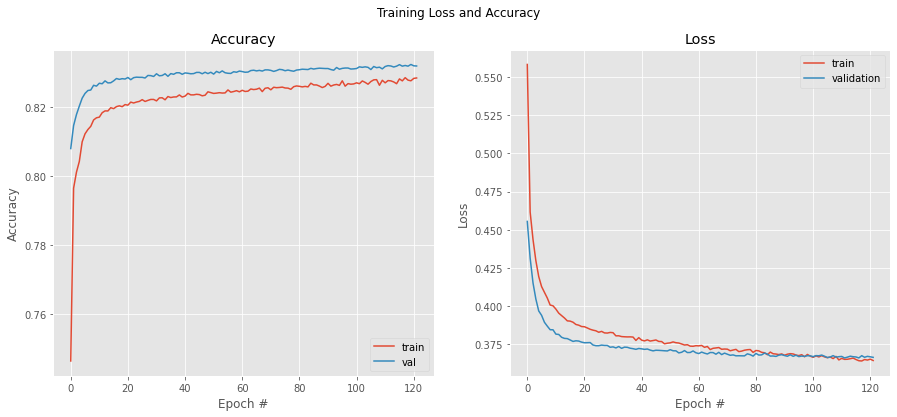

----------
Validation Loss: 0.366581
Validation Accuracy: 0.831984


In [13]:
#Training loss and accuracy plots
N = len(mfit.history['accuracy'])
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Training Loss and Accuracy')

ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="lower right")

ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="validation")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

plt.show()

#Results
score = model.evaluate(X_test, y_test, verbose=0)

print ("-"*10)
print ("Validation Loss: %f"%(score[0]))
print ("Validation Accuracy: %f"%(score[1]))

In [14]:
model_best = load_model(os.path.sep.join([root_dir,'model_bests_weights.hdf5']))
test_loss, test_val = model_best.evaluate(X_test, y_test, verbose=1)
print('El loss del conjunto de test es: ',round(test_loss,4),
      '\nF1 score del conjunto de test es:', round(test_val*100,2),'%')

637/637 [==============================] - 1s 2ms/step - loss: 0.3672 - accuracy: 0.8324
El loss del conjunto de test es:  0.3672 
F1 score del conjunto de test es: 83.24 %


In [15]:
# Obtaining metrics data full
y_pred = model_best.predict(X_test) > 0.5

acc_ann = accuracy_score(y_test, y_pred)
f1_ann = f1_score(y_test, y_pred)
precision_ann = precision_score(y_test, y_pred)
recall_ann = recall_score(y_test, y_pred)
auc_ann = roc_auc_score(y_test, y_pred)
print('Accuracy with ANN model: {0:.4f}'.format(acc_ann*100),'%')
print('F1_score with ANN model: {0:.4f}'.format(f1_ann*100),'%')
print('Precision with ANN model: {0:.4f}'.format(precision_ann*100),'%')
print('Recall with ANN model: {0:.4f}'.format(recall_ann*100),'%')
print('AUC with ANN model: {0:.4f}'.format(auc_ann*100),'%')

print(classification_report(y_test,y_pred))

637/637 [==============================] - 1s 2ms/step
Accuracy with ANN model: 83.2425 %
F1_score with ANN model: 78.9363 %
Precision with ANN model: 98.7191 %
Recall with ANN model: 65.7586 %
AUC with ANN model: 82.4895 %
              precision    recall  f1-score   support

           0       0.76      0.99      0.86     10645
           1       0.99      0.66      0.79      9728

    accuracy                           0.83     20373
   macro avg       0.87      0.82      0.83     20373
weighted avg       0.87      0.83      0.83     20373



Text(91.68, 0.5, 'Actual label')

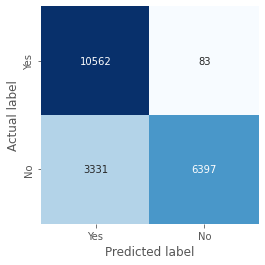

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Yes', 'No']
 
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')